In [26]:
pip install matplotlib seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [27]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import randint as sp_randint
import matplotlib.pyplot as plt
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import KBinsDiscretizer
import seaborn as sns
import matplotlib.pyplot as plt



In [28]:

# ============================================================
# 2. Load Dataset
# ============================================================
df = pd.read_csv("dataset.csv")
X = df.drop(columns=["Price"])
y = df["Price"]

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

df.head()



Airline Flight_no Time_Stamp_Date Time_Stamp_Time    Source Destination  \
0  IndiGo   6E 6813        20/11/25            0:00  Banglore   New Delhi   
1  IndiGo   6E 6813        20/11/25            3:00  Banglore   New Delhi   
2  IndiGo   6E 6813        20/11/25            6:00  Banglore   New Delhi   
3  IndiGo   6E 6813        20/11/25            9:00  Banglore   New Delhi   
4  IndiGo   6E 6813        20/11/25           12:00  Banglore   New Delhi   

       Route Dep_Time Arrival_Time Duration Total_Stops  Price  
0  BLR - DEL    23:30         2:25   2h 55m    non stop   6194  
1  BLR - DEL    23:30         2:25   2h 55m    non stop   6194  
2  BLR - DEL    23:30         2:25   2h 55m    non stop   6194  
3  BLR - DEL    23:30         2:25   2h 55m    non stop   6622  
4  BLR - DEL    23:30         2:25   2h 55m    non stop   6622

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [30]:

# ============================================================
# 3. Preprocessing Pipeline
# ============================================================
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)


In [31]:

# Random Forest + RandomizedSearchCV
# Parameter Space
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)# Parameter search space
param_dist = {
    "regressor__n_estimators": sp_randint(150, 500),
    "regressor__max_depth": sp_randint(5, 40),
    "regressor__min_samples_split": sp_randint(2, 25),
    "regressor__min_samples_leaf": sp_randint(1, 12),
    "regressor__max_features": ["auto", "sqrt", "log2", None]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", rf)
])

rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist,
    n_iter=35,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("\n🔍 Running RandomizedSearchCV...")
rf_search.fit(X_train, y_train)

print("\n🎯 Best Parameters:")
print(rf_search.best_params_)

best_rf_model = rf_search.best_estimator_



🔍 Running RandomizedSearchCV...
Fitting 3 folds for each of 35 candidates, totalling 105 fits
[CV] END regressor__max_depth=33, regressor__max_features=log2, regressor__min_samples_leaf=11, regressor__min_samples_split=9, regressor__n_estimators=338; total time=   0.5s
[CV] END regressor__max_depth=33, regressor__max_features=log2, regressor__min_samples_leaf=11, regressor__min_samples_split=9, regressor__n_estimators=338; total time=   0.5s
[CV] END regressor__max_depth=33, regressor__max_features=log2, regressor__min_samples_leaf=11, regressor__min_samples_split=9, regressor__n_estimators=338; total time=   0.5s
[CV] END regressor__max_depth=15, regressor__max_features=log2, regressor__min_samples_leaf=8, regressor__min_samples_split=22, regressor__n_estimators=249; total time=   0.4s
[CV] END regressor__max_depth=15, regressor__max_features=log2, regressor__min_samples_leaf=8, regressor__min_samples_split=22, regressor__n_estimators=249; total time=   0.4s
[CV] END regressor__max_d

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
21 fits failed out of a total of 105.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
17 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File 

In [32]:
# Evaluating the model
y_pred = best_rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 Model Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")



📊 Model Evaluation:
RMSE: 511.5034
MAE : 400.2522
R²  : 0.9611


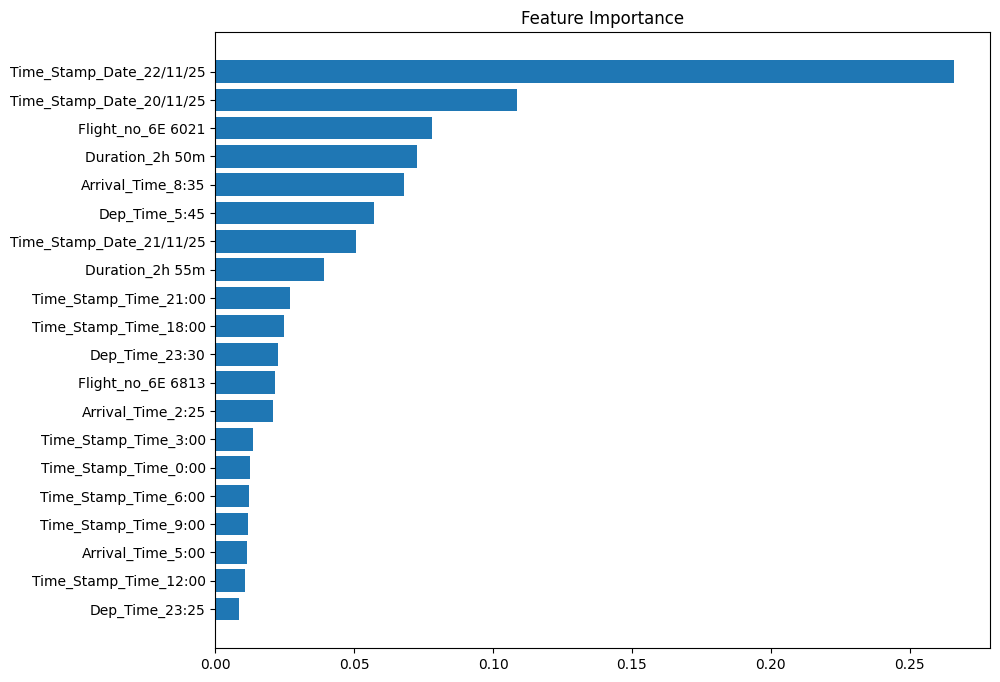

In [33]:
# Extract trained RandomForest
rf_model = best_rf_model.named_steps["regressor"]

# Extract built one-hot category names
cat_features = best_rf_model.named_steps["preprocessor"] \
    .named_transformers_["cat"]["onehot"] \
    .get_feature_names_out(categorical_cols)

all_features = np.concatenate([numerical_cols, cat_features])

# RF feature importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 8))
plt.title("Feature Importance")
plt.barh(all_features[indices][:20], importances[indices][:20])
plt.gca().invert_yaxis()
plt.show()


In [34]:
# Example: predict using first 5 rows of test set
new_predictions = best_rf_model.predict(X_test.head())
new_predictions


array([7405.58508571, 6864.52465873, 6782.52122063, 8228.31527778,
       7967.65327143])

In [35]:
# to save the model
import joblib

# Save the full pipeline (preprocessor + model)
joblib.dump(best_rf_model, "random_forest_price_model.pkl")

print("✅ Model saved as random_forest_price_model.pkl")


✅ Model saved as random_forest_price_model.pkl


/var/folders/49/c1gkj9810kzbk008hr0xrmcm0000gn/T/ipykernel_22202/3022337393.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Time_Stamp"] = pd.to_datetime(df["Time_Stamp_Date"] + " " + df["Time_Stamp_Time"])


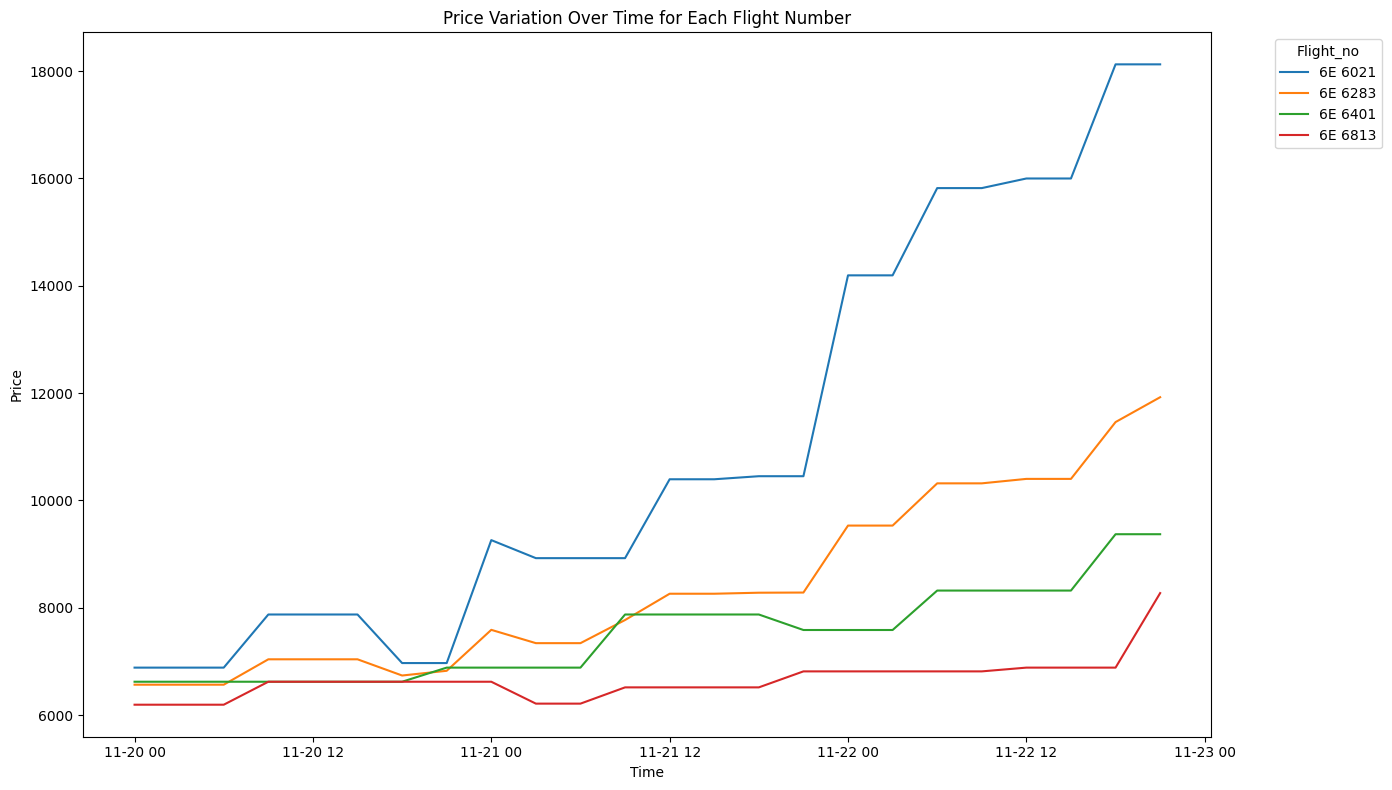

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# Combine date + time into a single timestamp
df["Time_Stamp"] = pd.to_datetime(df["Time_Stamp_Date"] + " " + df["Time_Stamp_Time"])

# Sort the dataset properly
df_sorted = df.sort_values(by=["Flight_no", "Time_Stamp"])

# Get each unique flight number
flight_numbers = df_sorted["Flight_no"].unique()

plt.figure(figsize=(14, 8))

# Plot each flight's price over time
for flight in flight_numbers:
    temp = df_sorted[df_sorted["Flight_no"] == flight]
    plt.plot(temp["Time_Stamp"], temp["Price"], label=str(flight))

plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Price Variation Over Time for Each Flight Number")
plt.legend(title="Flight_no", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


/var/folders/49/c1gkj9810kzbk008hr0xrmcm0000gn/T/ipykernel_22202/3881970275.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time_Stamp_Date'] = pd.to_datetime(df['Time_Stamp_Date'], dayfirst=True, errors='coerce')


                 Airline     Flight_no  Time_Stamp_Date  Time_Stamp_Time  \
Airline              NaN           NaN              NaN              NaN   
Flight_no            NaN  1.000000e+00    -2.785724e-12     2.752574e-16   
Time_Stamp_Date      NaN -2.785724e-12     1.000000e+00    -2.114957e-13   
Time_Stamp_Time      NaN  2.752574e-16    -2.114957e-13     1.000000e+00   
Source               NaN           NaN              NaN              NaN   
Destination          NaN           NaN              NaN              NaN   
Route                NaN  2.581989e-01     1.749218e-11     8.487819e-17   
Dep_Time             NaN  6.390544e-01    -1.525161e-11     1.433934e-16   
Arrival_Time         NaN -1.669303e-01     1.414304e-11    -9.861578e-17   
Duration             NaN -2.314821e-01    -1.754608e-11    -8.273374e-17   
Total_Stops          NaN  2.581989e-01     1.749218e-11     8.487819e-17   
Price                NaN -5.817148e-01     5.621276e-01     1.480727e-01   
Time_Stamp  

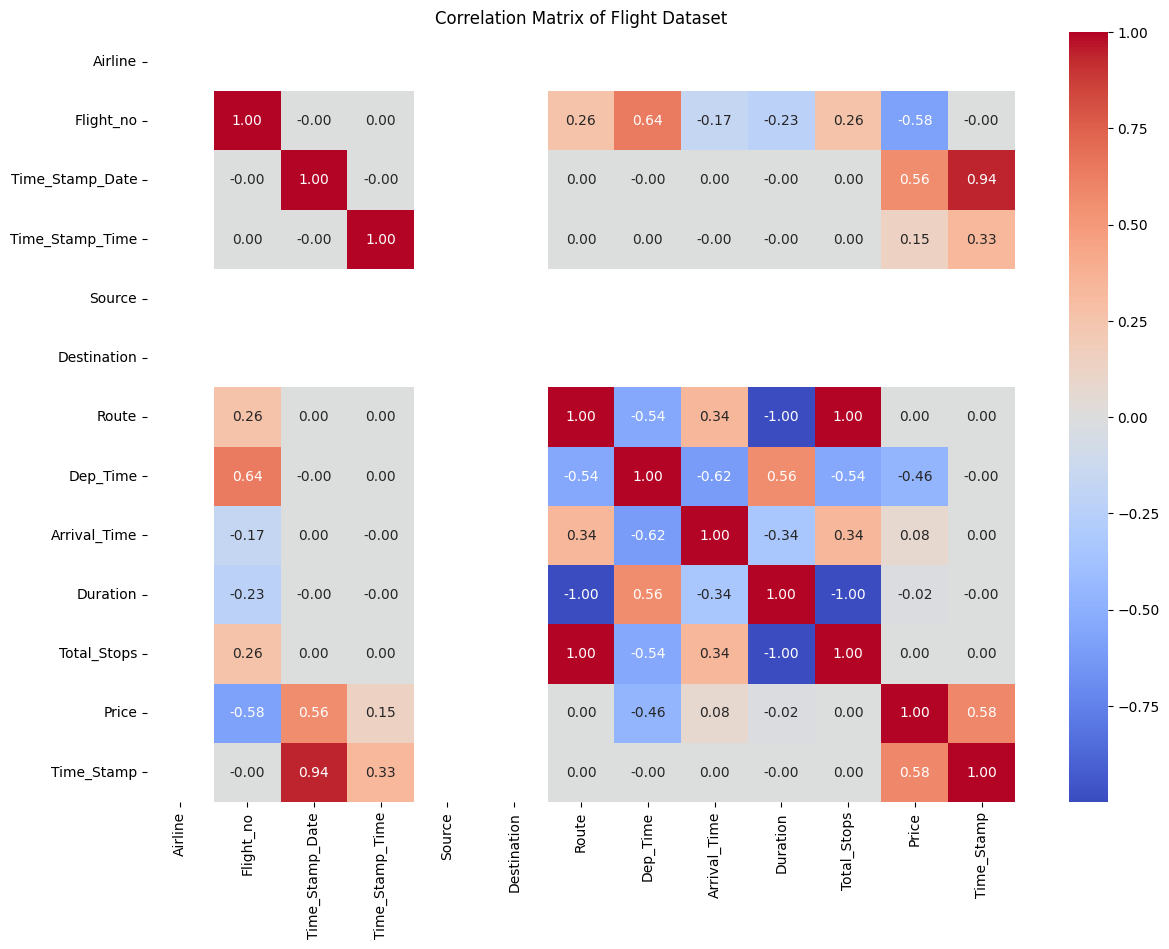

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ============================
# 1. Convert date to datetime
# ============================
df['Time_Stamp_Date'] = pd.to_datetime(df['Time_Stamp_Date'], dayfirst=True, errors='coerce')
df['Time_Stamp_Date'] = df['Time_Stamp_Date'].map(lambda x: x.toordinal() if pd.notnull(x) else None)

# ============================
# 2. Convert time columns to seconds
# ============================
def time_to_seconds(t):
    try:
        h, m = t.split(':')
        return int(h) * 3600 + int(m) * 60
    except:
        return None

df['Time_Stamp_Time'] = df['Time_Stamp_Time'].apply(time_to_seconds)
df['Dep_Time'] = df['Dep_Time'].apply(time_to_seconds)
df['Arrival_Time'] = df['Arrival_Time'].apply(time_to_seconds)

# ============================
# 3. Convert Duration "2h 40m" → minutes
# ============================
def parse_duration(d):
    try:
        h = int(d.split('h')[0].strip())
        m = int(d.split('h')[1].replace('m','').strip())
        return h*60 + m
    except:
        return None

df['Duration'] = df['Duration'].apply(parse_duration)

# ============================
# 4. Convert categorical to codes
# ============================
categorical_cols = ['Airline','Flight_no','Source','Destination','Route','Total_Stops']

df_encoded = df.copy()
for col in categorical_cols:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# ============================
# 5. Correlation Matrix
# ============================
corr_matrix = df_encoded.corr()

print(corr_matrix)

# ============================
# 6. Plot Heatmap
# ============================
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Flight Dataset")
plt.show()


In [38]:
# GradientBoosting (sklearn) — baseline + evaluate

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

gbr = GradientBoostingRegressor(random_state=42)

gbr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", gbr)
])

gbr_pipeline.fit(X_train, y_train)
pred_gbr = gbr_pipeline.predict(X_test)

rmse_gbr = np.sqrt(mean_squared_error(y_test, pred_gbr))
mae_gbr = mean_absolute_error(y_test, pred_gbr)
r2_gbr = r2_score(y_test, pred_gbr)

print("GBR  -> RMSE:", rmse_gbr, "MAE:", mae_gbr, "R2:", r2_gbr)


GBR  -> RMSE: 371.54751924754066 MAE: 246.19113778103733 R2: 0.9794857008810962


In [39]:
# GradientBoosting — tuned (RandomizedSearchCV)

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint, uniform

param_dist_gbr = {
    "regressor__n_estimators": sp_randint(50, 500),
    "regressor__learning_rate": uniform(0.01, 0.5),
    "regressor__max_depth": sp_randint(2, 8),
    "regressor__min_samples_leaf": sp_randint(1, 20),
    "regressor__subsample": uniform(0.5, 0.5)
}

gbr = GradientBoostingRegressor(random_state=42)
gbr_pipeline = Pipeline([("preprocessor", preprocessor), ("regressor", gbr)])

gbr_search = RandomizedSearchCV(
    estimator=gbr_pipeline,
    param_distributions=param_dist_gbr,
    n_iter=30,
    cv=3,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

gbr_search.fit(X_train, y_train)
best_gbr = gbr_search.best_estimator_
pred_gbr_t = best_gbr.predict(X_test)

rmse_gbr_t = np.sqrt(mean_squared_error(y_test, pred_gbr_t))
mae_gbr_t = mean_absolute_error(y_test, pred_gbr_t)
r2_gbr_t = r2_score(y_test, pred_gbr_t)

print("Tuned GBR best params:", gbr_search.best_params_)
print("Tuned GBR -> RMSE:", rmse_gbr_t, "MAE:", mae_gbr_t, "R2:", r2_gbr_t)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Tuned GBR best params: {'regressor__learning_rate': np.float64(0.1473608964950321), 'regressor__max_depth': 4, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 276, 'regressor__subsample': np.float64(0.5597971229691509)}
Tuned GBR -> RMSE: 477.91232779013416 MAE: 375.35662143282707 R2: 0.9660590168268159


In [40]:
# XGBoost (XGBRegressor) — baseline + evaluate

from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)

xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", xgb)
])

xgb_pipeline.fit(X_train, y_train)
pred_xgb = xgb_pipeline.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
mae_xgb = mean_absolute_error(y_test, pred_xgb)
r2_xgb = r2_score(y_test, pred_xgb)

print("XGB  -> RMSE:", rmse_xgb, "MAE:", mae_xgb, "R2:", r2_xgb)


XGB  -> RMSE: 1035.287580819938 MAE: 545.6265869140625 R2: 0.8407241106033325


In [41]:
# XGBoost — tuned (RandomizedSearchCV)

param_dist_xgb = {
    "regressor__n_estimators": sp_randint(50, 700),
    "regressor__max_depth": sp_randint(3, 12),
    "regressor__learning_rate": uniform(0.01, 0.4),
    "regressor__subsample": uniform(0.5, 0.5),
    "regressor__colsample_bytree": uniform(0.5, 0.5),
    "regressor__reg_alpha": uniform(0, 1),
    "regressor__reg_lambda": uniform(0, 1)
}

xgb = XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)
xgb_pipeline = Pipeline([("preprocessor", preprocessor), ("regressor", xgb)])

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_dist_xgb,
    n_iter=40,
    cv=3,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
pred_xgb_t = best_xgb.predict(X_test)

rmse_xgb_t = np.sqrt(mean_squared_error(y_test, pred_xgb_t))
mae_xgb_t = mean_absolute_error(y_test, pred_xgb_t)
r2_xgb_t = r2_score(y_test, pred_xgb_t)

print("Tuned XGB best params:", xgb_search.best_params_)
print("Tuned XGB -> RMSE:", rmse_xgb_t, "MAE:", mae_xgb_t, "R2:", r2_xgb_t)


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Tuned XGB best params: {'regressor__colsample_bytree': np.float64(0.8035171238433423), 'regressor__learning_rate': np.float64(0.12039967280901735), 'regressor__max_depth': 3, 'regressor__n_estimators': 570, 'regressor__reg_alpha': np.float64(0.7722447692966574), 'regressor__reg_lambda': np.float64(0.1987156815341724), 'regressor__subsample': np.float64(0.5027610585618012)}
Tuned XGB -> RMSE: 468.0136716753048 MAE: 318.464599609375 R2: 0.9674504399299622


In [42]:
#LightGBM (LGBMRegressor) — baseline + evaluate

from lightgbm import LGBMRegressor

lgb = LGBMRegressor(random_state=42, n_jobs=-1)

lgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", lgb)
])

lgb_pipeline.fit(X_train, y_train)
pred_lgb = lgb_pipeline.predict(X_test)

rmse_lgb = np.sqrt(mean_squared_error(y_test, pred_lgb))
mae_lgb = mean_absolute_error(y_test, pred_lgb)
r2_lgb = r2_score(y_test, pred_lgb)

print("LGB  -> RMSE:", rmse_lgb, "MAE:", mae_lgb, "R2:", r2_lgb)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 8
[LightGBM] [Info] Start training from score 8503.526316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [43]:
# LightGBM — tuned (RandomizedSearchCV)

param_dist_lgb = {
    "regressor__n_estimators": sp_randint(50, 800),
    "regressor__num_leaves": sp_randint(20, 200),
    "regressor__learning_rate": uniform(0.01, 0.4),
    "regressor__min_child_samples": sp_randint(5, 100),
    "regressor__subsample": uniform(0.5, 0.5),
    "regressor__colsample_bytree": uniform(0.5, 0.5)
}

lgb = LGBMRegressor(random_state=42, n_jobs=-1)
lgb_pipeline = Pipeline([("preprocessor", preprocessor), ("regressor", lgb)])

lgb_search = RandomizedSearchCV(
    estimator=lgb_pipeline,
    param_distributions=param_dist_lgb,
    n_iter=40,
    cv=3,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

lgb_search.fit(X_train, y_train)
best_lgb = lgb_search.best_estimator_
pred_lgb_t = best_lgb.predict(X_test)

rmse_lgb_t = np.sqrt(mean_squared_error(y_test, pred_lgb_t))
mae_lgb_t = mean_absolute_error(y_test, pred_lgb_t)
r2_lgb_t = r2_score(y_test, pred_lgb_t)

print("Tuned LGB best params:", lgb_search.best_params_)
print("Tuned LGB -> RMSE:", rmse_lgb_t, "MAE:", mae_lgb_t, "R2:", r2_lgb_t)


Fitting 3 folds for each of 40 candidates, totalling 120 fits
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 0
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 0
[LightGBM] [Info] Total Bins 0
[LightGBM] [I

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/skle

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/skle

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 8418.568627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further 

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/skle

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split re

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/skle

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/skle

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 0
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Start training from score 8678.411765
[LightGBM] [Warning] Stopped training because there 

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/skle

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best 

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/skle

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split re

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/skle

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split re

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/skle

 leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there a

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because t

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 8411.800000
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 0
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 8411.800000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warnin

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/skle

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/skle

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because t

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/skle

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [44]:
# MLPRegressor (neural net) — baseline + evaluate

from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(random_state=42, max_iter=1000)

mlp_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", mlp)
])

mlp_pipeline.fit(X_train, y_train)
pred_mlp = mlp_pipeline.predict(X_test)

rmse_mlp = np.sqrt(mean_squared_error(y_test, pred_mlp))
mae_mlp = mean_absolute_error(y_test, pred_mlp)
r2_mlp = r2_score(y_test, pred_mlp)

print("MLP  -> RMSE:", rmse_mlp, "MAE:", mae_mlp, "R2:", r2_mlp)


MLP  -> RMSE: 6816.633507157641 MAE: 6304.564938634753 R2: -5.905066123592812


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [45]:
# Stacking Regressor (meta-estimator) — baseline

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

estimators = [
    ("gbr", GradientBoostingRegressor(random_state=42)),
    ("xgb", XGBRegressor(random_state=42, verbosity=0)),
    ("lgb", LGBMRegressor(random_state=42))
]

stack = StackingRegressor(estimators=estimators, final_estimator=Ridge(), n_jobs=-1)

stack_pipeline = Pipeline([("preprocessor", preprocessor), ("regressor", stack)])
stack_pipeline.fit(X_train, y_train)
pred_stack = stack_pipeline.predict(X_test)

rmse_stack = np.sqrt(mean_squared_error(y_test, pred_stack))
mae_stack = mean_absolute_error(y_test, pred_stack)
r2_stack = r2_score(y_test, pred_stack)

print("Stack -> RMSE:", rmse_stack, "MAE:", mae_stack, "R2:", r2_stack)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 8
[LightGBM] [Info] Start training from score 8503.526316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/skle

In [46]:
# Voting Regressor (averaging) — baseline
from sklearn.ensemble import VotingRegressor

voting = VotingRegressor(
    estimators=[
        ("gbr", GradientBoostingRegressor(random_state=42)),
        ("xgb", XGBRegressor(random_state=42, verbosity=0)),
        ("lgb", LGBMRegressor(random_state=42))
    ],
    n_jobs=-1
)

voting_pipeline = Pipeline([("preprocessor", preprocessor), ("regressor", voting)])
voting_pipeline.fit(X_train, y_train)
pred_voting = voting_pipeline.predict(X_test)

rmse_voting = np.sqrt(mean_squared_error(y_test, pred_voting))
mae_voting = mean_absolute_error(y_test, pred_voting)
r2_voting = r2_score(y_test, pred_voting)

print("Voting -> RMSE:", rmse_voting, "MAE:", mae_voting, "R2:", r2_voting)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 8
[LightGBM] [Info] Start training from score 8503.526316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [47]:
# Stacking/Tuned (RandomizedSearchCV on a simpler stacking meta-parameter)

# Example: tune final estimator alpha if using Ridge as final_estimator
from sklearn.linear_model import Ridge
stack = StackingRegressor(
    estimators=[("gbr", GradientBoostingRegressor(random_state=42)),
                ("xgb", XGBRegressor(random_state=42, verbosity=0))],
    final_estimator=Ridge()
)

stack_pipeline = Pipeline([("preprocessor", preprocessor), ("regressor", stack)])

param_dist_stack = {
    "regressor__final_estimator__alpha": uniform(0.01, 10)
}

stack_search = RandomizedSearchCV(
    estimator=stack_pipeline,
    param_distributions=param_dist_stack,
    n_iter=20,
    cv=3,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

stack_search.fit(X_train, y_train)
best_stack = stack_search.best_estimator_
pred_stack_t = best_stack.predict(X_test)

rmse_stack_t = np.sqrt(mean_squared_error(y_test, pred_stack_t))
mae_stack_t = mean_absolute_error(y_test, pred_stack_t)
r2_stack_t = r2_score(y_test, pred_stack_t)

print("Tuned Stack best params:", stack_search.best_params_)
print("Tuned Stack -> RMSE:", rmse_stack_t, "MAE:", mae_stack_t, "R2:", r2_stack_t)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Tuned Stack best params: {'regressor__final_estimator__alpha': np.float64(0.21584494295802448)}
Tuned Stack -> RMSE: 332.4173672457865 MAE: 232.94985903744447 R2: 0.9835791602493961


In [48]:
import pandas as pd
results = []

# Append baseline results (replace variable names with ones you executed)
results.append(["RandomForest", rmse, mae, r2])
results.append(["GradientBoosting", rmse_gbr, mae_gbr, r2_gbr])
results.append(["GBR_Tuned", rmse_gbr_t, mae_gbr_t, r2_gbr_t])

results.append(["XGBoost", rmse_xgb, mae_xgb, r2_xgb])
results.append(["XGBoost_Tuned", rmse_xgb_t, mae_xgb_t, r2_xgb_t])

results.append(["LightGBM", rmse_lgb, mae_lgb, r2_lgb])
results.append(["LightGBM_Tuned", rmse_lgb_t, mae_lgb_t, r2_lgb_t])

results.append(["MLP", rmse_mlp, mae_mlp, r2_mlp])

results.append(["Stacking", rmse_stack, mae_stack, r2_stack])
results.append(["Stacking_Tuned", rmse_stack_t, mae_stack_t, r2_stack_t])

results.append(["Voting", rmse_voting, mae_voting, r2_voting])

df_results = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "R2"])
df_results = df_results.sort_values("RMSE").reset_index(drop=True)
print(df_results)


               Model         RMSE          MAE        R2
0     Stacking_Tuned   332.417367   232.949859  0.983579
1           Stacking   335.190181   234.506493  0.983304
2   GradientBoosting   371.547519   246.191138  0.979486
3      XGBoost_Tuned   468.013672   318.464600  0.967450
4          GBR_Tuned   477.912328   375.356621  0.966059
5     LightGBM_Tuned   487.554448   321.608408  0.964676
6             Voting   495.401223   337.662583  0.963529
7       RandomForest   511.503431   400.252226  0.961120
8           LightGBM   815.686110   647.611376  0.901128
9            XGBoost  1035.287581   545.626587  0.840724
10               MLP  6816.633507  6304.564939 -5.905066


In [49]:
# To save to CSV
df_results.to_csv("model_comparison_results.csv", index=False)

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


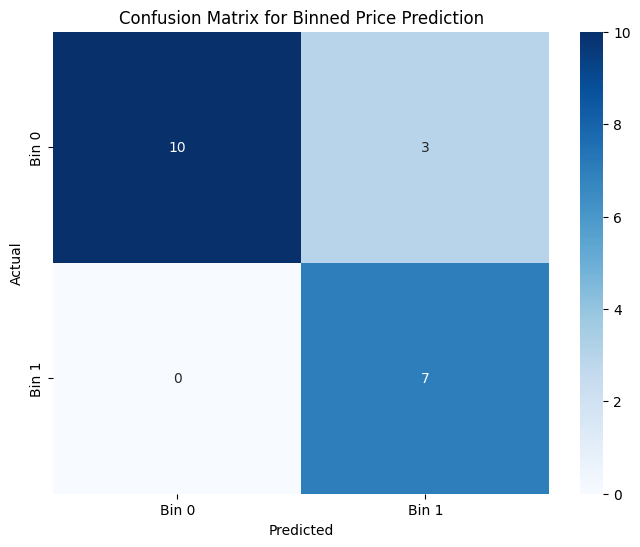

Classification Report for Binned Price Prediction:
               precision    recall  f1-score   support

         0.0       1.00      0.77      0.87        13
         1.0       0.70      1.00      0.82         7

    accuracy                           0.85        20
   macro avg       0.85      0.88      0.85        20
weighted avg       0.89      0.85      0.85        20



In [50]:
# confusion matrix and classification report for binned price prediction
# Binning the target variable into categories
est = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile')
y_binned = est.fit_transform(y.values.reshape(-1, 1)).ravel()
y_test_binned = est.transform(y_test.values.reshape(-1, 1)).ravel()
y_pred_binned = est.transform(y_pred.reshape(-1, 1)).ravel()
# Confusion Matrix
cm = confusion_matrix(y_test_binned, y_pred_binned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Bin {i}' for i in range(2)],
            yticklabels=[f'Bin {i}' for i in range(2)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Binned Price Prediction')
plt.show()                                                                                                                                                                                                                                                                                  
# Classification Report
report = classification_report(y_test_binned, y_pred_binned)
print("Classification Report for Binned Price Prediction:\n", report)
